In [ ]:
# Load Libraries
import pandas as pd
import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt

In [ ]:
# Seed
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759/Data')
Data1 = loadmat('p5759_Inputs.mat')
Data2 = loadmat('p5759_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),
                         'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),
                       'physics_out':Data2['physics_out'].ravel().round(2), 'SR':Data2['SR'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df = df[['K','V','AE','Amp','SS','TTF','ln_V_V0','SR','physics_out','Time']]
df_AE = df[['AE','AE']]
df_SS = df[['K','V','AE','Amp','SS']]
df_TTF = df[['K','V','AE','Amp','TTF']]
df_SR = df[['K','V','AE','Amp','ln_V_V0']]
xdf = df[['K','V','AE','Amp']]
ydf = df[['SS','TTF','ln_V_V0']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
                 K      V     AE       Amp
0      3511910.82  23.33   1.50  12313.25
1      3511805.49  23.16   1.67  12390.65
2         3807.30  16.44   1.67  12433.71
3          992.68  16.27   1.33  12425.59
4          999.61  16.27   1.33  12417.39
...           ...    ...    ...       ...
2549  46495304.45  57.63  21.00  14054.81
2550  28519703.48  45.56  28.00  14150.11
2551  28519724.49  45.56  26.67  14268.53
2552  28519838.19  45.57   8.67  14322.32
2553  28519979.30  45.56   2.00  14373.05

[2554 rows x 4 columns]
Target Data:
          SS   TTF  ln_V_V0
0     11.43  0.00   -11.51
1     11.46  5.78   -11.51
2     11.54  5.67   -11.51
3     11.65  5.56   -11.51
4     11.73  5.46   -11.51
...     ...   ...      ...
2549  12.79  0.00   -11.51
2550  11.50  0.00     1.45
2551  11.33  0.00   -11.51
2552  11.41  0.00   -11.51
2553  11.52  0.00   -11.51

[2554 rows x 3 columns]


In [ ]:
# Preprocessing (AE)
arr = df_AE.to_numpy()
n_steps = 100
xdf_AE, ydf_AE = create_timesteps(arr, n_steps)

# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 100
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (TTF)
arr = df_TTF.to_numpy()
n_steps = 100
xdf, ydf_TTF = create_timesteps(arr, n_steps)

# Preprocessing (SR)
arr = df_SR.to_numpy()
n_steps = 100
xdf, ydf_SR = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (TTF), Y = ', np.shape(ydf_TTF))
print('Target shape (SR), Y = ', np.shape(ydf_SR))
print('Target shape (AE), Y = ', np.shape(ydf_AE))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

# Reshape AE
in_dim = xdf_AE.shape[1]*xdf_AE.shape[2]
xdf_AE = xdf_AE.reshape((xdf_AE.shape[0], in_dim))
print('After reshaping, xdf_AE = ', np.shape(xdf_AE))

Features shape, X =  (2454, 100, 4)
Target shape (SS), Y =  (2454,)
Target shape (TTF), Y =  (2454,)
Target shape (SR), Y =  (2454,)
Target shape (AE), Y =  (2454,)
After reshaping, X =  (2454, 400)
After reshaping, xdf_AE =  (2454, 100)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (TTF)
x_train, x_test, y_train_TTF, y_test_TTF = train_test_split(xdf, ydf_TTF, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_TTF, Y_val_TTF = train_test_split(x_train, y_train_TTF, test_size=0.125, shuffle=False)

# Split into train-val-test (SR)
x_train, x_test, y_train_SR, y_test_SR = train_test_split(xdf, ydf_SR, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SR, Y_val_SR = train_test_split(x_train, y_train_SR, test_size=0.125, shuffle=False)

# Split into train-val-test (AE)
x_train, x_test, y_train_AE, y_test_AE = train_test_split(xdf, xdf_AE, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_AE, Y_val_AE = train_test_split(x_train, y_train_AE, test_size=0.125, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 1717
Validation samples: 246
Testing samples: 491


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler(feature_range=(0, 1))
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: TTF
scaler_ttf = MinMaxScaler(feature_range=(0, 1))
Y_train_TTF = pd.DataFrame(scaler_ttf.fit_transform(Y_train_TTF.reshape(-1, 1)))
Y_val_TTF = pd.DataFrame(scaler_ttf.transform(Y_val_TTF.reshape(-1, 1)))
y_test_TTF = pd.DataFrame(scaler_ttf.transform(y_test_TTF.reshape(-1, 1)))

In [ ]:
# # Normalize the output: SR
scaler_sr = MinMaxScaler(feature_range=(-1, 1))
Y_train_SR = pd.DataFrame(scaler_sr.fit_transform(Y_train_SR.reshape(-1, 1)))
Y_val_SR = pd.DataFrame(scaler_sr.transform(Y_val_SR.reshape(-1, 1)))
y_test_SR = pd.DataFrame(scaler_sr.transform(y_test_SR.reshape(-1, 1)))

In [ ]:
# Normalize the input: AE
scaler_ae = MinMaxScaler(feature_range=(0, 1))
Y_train_AE = pd.DataFrame(scaler_ae.fit_transform(Y_train_AE))
Y_val_AE = pd.DataFrame(scaler_ae.transform(Y_val_AE))
y_test_AE = pd.DataFrame(scaler_ae.transform(y_test_AE))

In [ ]:
# Define DD Model
def MLP_Physics():

  # Define inputs
  X_train = layers.Input(shape=(400),name='X_train')
  AE =layers.Input(shape=(100),name='AE')

  # Prediction: Shear Stress + TTF
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)

  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  ttf_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  # # Prediction: SR
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(AE)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  sr_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train,AE],outputs=[ss_pred,ttf_pred,sr_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Physics()
model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 X_train (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 AE (InputLayer)             [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  51328     ['X_train[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 128)                  12928     ['AE[0][0]']                  
                                                                                              

Train on 1717 samples, validate on 246 samples
Epoch 1/100
1717/1717 [==============================] - 1s 525us/sample - loss: 1.2130 - dense_5_loss: 0.2609 - dense_6_loss: 0.1766 - dense_12_loss: 0.7694 - dense_5_mse: 0.2621 - dense_6_mse: 0.1770 - dense_12_mse: 0.7739 - val_loss: 0.3215 - val_dense_5_loss: 0.1223 - val_dense_6_loss: 0.1073 - val_dense_12_loss: 0.0908 - val_dense_5_mse: 0.1222 - val_dense_6_mse: 0.1062 - val_dense_12_mse: 0.0931
Epoch 2/100
  32/1717 [..............................] - ETA: 0s - loss: 0.6867 - dense_5_loss: 0.1171 - dense_6_loss: 0.1111 - dense_12_loss: 0.4584 - dense_5_mse: 0.1171 - dense_6_mse: 0.1111 - dense_12_mse: 0.4584

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1717/1717 [==============================] - 0s 181us/sample - loss: 0.2561 - dense_5_loss: 0.0857 - dense_6_loss: 0.0886 - dense_12_loss: 0.0812 - dense_5_mse: 0.0858 - dense_6_mse: 0.0887 - dense_12_mse: 0.0816 - val_loss: 0.3199 - val_dense_5_loss: 0.1232 - val_dense_6_loss: 0.1108 - val_dense_12_loss: 0.0834 - val_dense_5_mse: 0.1241 - val_dense_6_mse: 0.1111 - val_dense_12_mse: 0.0848
Epoch 3/100
1717/1717 [==============================] - 0s 176us/sample - loss: 0.2195 - dense_5_loss: 0.0744 - dense_6_loss: 0.0827 - dense_12_loss: 0.0620 - dense_5_mse: 0.0746 - dense_6_mse: 0.0826 - dense_12_mse: 0.0622 - val_loss: 0.2663 - val_dense_5_loss: 0.0974 - val_dense_6_loss: 0.0891 - val_dense_12_loss: 0.0777 - val_dense_5_mse: 0.0982 - val_dense_6_mse: 0.0894 - val_dense_12_mse: 0.0788
Epoch 4/100
1717/1717 [==============================] - 0s 193us/sample - loss: 0.2008 - dense_5_loss: 0.0616 - dense_6_loss: 0.0809 - dense_12_loss: 0.0580 - dense_5_mse: 0.0616 - dense_6_mse: 0.0810 

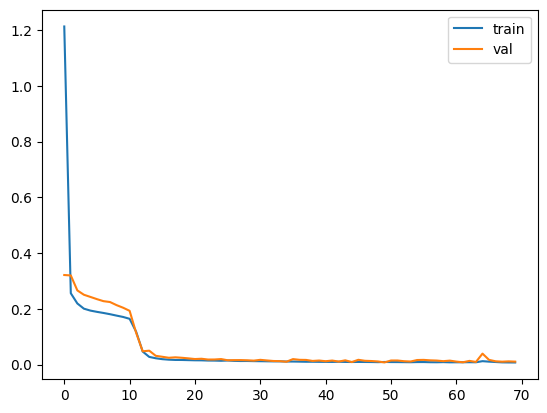

---Training time: 19.82124805 seconds ---


In [ ]:
# Train The Model
start_time = time.time()
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')
callbacks_list = [earlystop]
history = model.fit([X_train,Y_train_AE],[Y_train_SS,Y_train_TTF,Y_train_SR], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val,Y_val_AE],[Y_val_SS,Y_val_TTF,Y_val_SR]), verbose=1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# Predictions: Training
y_predtrain = model.predict([X_train,Y_train_AE])
y_predtrain_SS = np.array(y_predtrain)[0,]
y_predtrain_TTF =np.array(y_predtrain)[1,]
y_predtrain_SR =np.array(y_predtrain)[2,]

# Predictions: Validation
y_predval = model.predict([X_val,Y_val_AE])
y_predval_SS = np.array(y_predval)[0,]
y_predval_TTF =np.array(y_predval)[1,]
y_predval_SR =np.array(y_predval)[2,]

# Predictions: Testing
y_predtest = model.predict([x_test,y_test_AE])
y_predtest_SS = np.array(y_predtest)[0,]
y_predtest_TTF =np.array(y_predtest)[1,]
y_predtest_SR =np.array(y_predtest)[2,]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Inverse scaling: SS
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

# Inverse scaling: TTF
Y_train_TTF = scaler_ttf.inverse_transform(Y_train_TTF)
Y_val_TTF = scaler_ttf.inverse_transform(Y_val_TTF)
y_test_TTF = scaler_ttf.inverse_transform(y_test_TTF)
y_predtrain_TTF = scaler_ttf.inverse_transform(y_predtrain_TTF)
y_predval_TTF = scaler_ttf.inverse_transform(y_predval_TTF)
y_predtest_TTF = scaler_ttf.inverse_transform(y_predtest_TTF)

# Inverse scaling: SR
Y_train_SR = scaler_sr.inverse_transform(Y_train_SR)
Y_val_SR = scaler_sr.inverse_transform(Y_val_SR)
y_test_SR = scaler_sr.inverse_transform(y_test_SR)
y_predtrain_SR = scaler_sr.inverse_transform(y_predtrain_SR)
y_predval_SR = scaler_sr.inverse_transform(y_predval_SR)
y_predtest_SR = scaler_sr.inverse_transform(y_predtest_SR)

In [ ]:
# Model Performance: Training
train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

train_r2_TTF = r2_score(Y_train_TTF, y_predtrain_TTF)
train_rmse_TTF = np.sqrt(mean_squared_error(Y_train_TTF, y_predtrain_TTF))

train_r2_SR = r2_score(Y_train_SR, y_predtrain_SR)
train_rmse_SR = np.sqrt(mean_squared_error(Y_train_SR, y_predtrain_SR))

# Model Performance: Validation
val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

val_r2_TTF = r2_score(Y_val_TTF, y_predval_TTF)
val_rmse_TTF = np.sqrt(mean_squared_error(Y_val_TTF, y_predval_TTF))

val_r2_SR = r2_score(Y_val_SR, y_predval_SR)
val_rmse_SR = np.sqrt(mean_squared_error(Y_val_SR, y_predval_SR))

# Model Performance: Testing
test_r2_SS = r2_score(y_test_SS, y_predtest_SS)
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS))

test_r2_TTF = r2_score(y_test_TTF, y_predtest_TTF)
test_rmse_TTF = np.sqrt(mean_squared_error(y_test_TTF, y_predtest_TTF))

test_r2_SR = r2_score(y_test_SR, y_predtest_SR)
test_rmse_SR = np.sqrt(mean_squared_error(y_test_SR, y_predtest_SR))

In [ ]:
# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (TTF) - %0.5f, Train (SR) - %0.5f" %(train_r2_SS, train_r2_TTF, train_r2_SR))
print("R2 scores: Val (SS) - %0.5f, Val (TTF) - %0.5f, Val (SR) - %0.5f" %(val_r2_SS, val_r2_TTF, val_r2_SR))
print("R2 scores: Test (SS) - %0.5f, Test (TTF) - %0.5f, Test (SR) - %0.5f" %(test_r2_SS, test_r2_TTF, test_r2_SR))

R2 scores: Train (SS) - 0.97761, Train (TTF) - 0.99418, Train (SR) - 0.91580
R2 scores: Val (SS) - 0.95939, Val (TTF) - 0.93710, Val (SR) - 0.96864
R2 scores: Test (SS) - 0.91333, Test (TTF) - 0.88590, Test (SR) - 0.72588


In [ ]:
# Print RMSE Results
print("RMSE: Train (SS) - %0.5f, Train (TTF) - %0.5f, Train (SR) - %0.5f" %(train_rmse_SS, train_rmse_TTF, train_rmse_SR))
print("RMSE: Val (SS) - %0.5f, Val (TTF) - %0.5f, Val (SR) - %0.5f" %(val_rmse_SS, val_rmse_TTF, val_rmse_SR))
print("RMSE: Test (SS) - %0.5f, Test (TTF) - %0.5f, Test (SR) - %0.5f" %(test_rmse_SS, test_rmse_TTF, test_rmse_SR))

RMSE: Train (SS) - 0.05171, Train (TTF) - 0.14425, Train (SR) - 0.48830
RMSE: Val (SS) - 0.07506, Val (TTF) - 0.51069, Val (SR) - 0.29277
RMSE: Test (SS) - 0.11360, Test (TTF) - 0.69138, Test (SR) - 0.89730


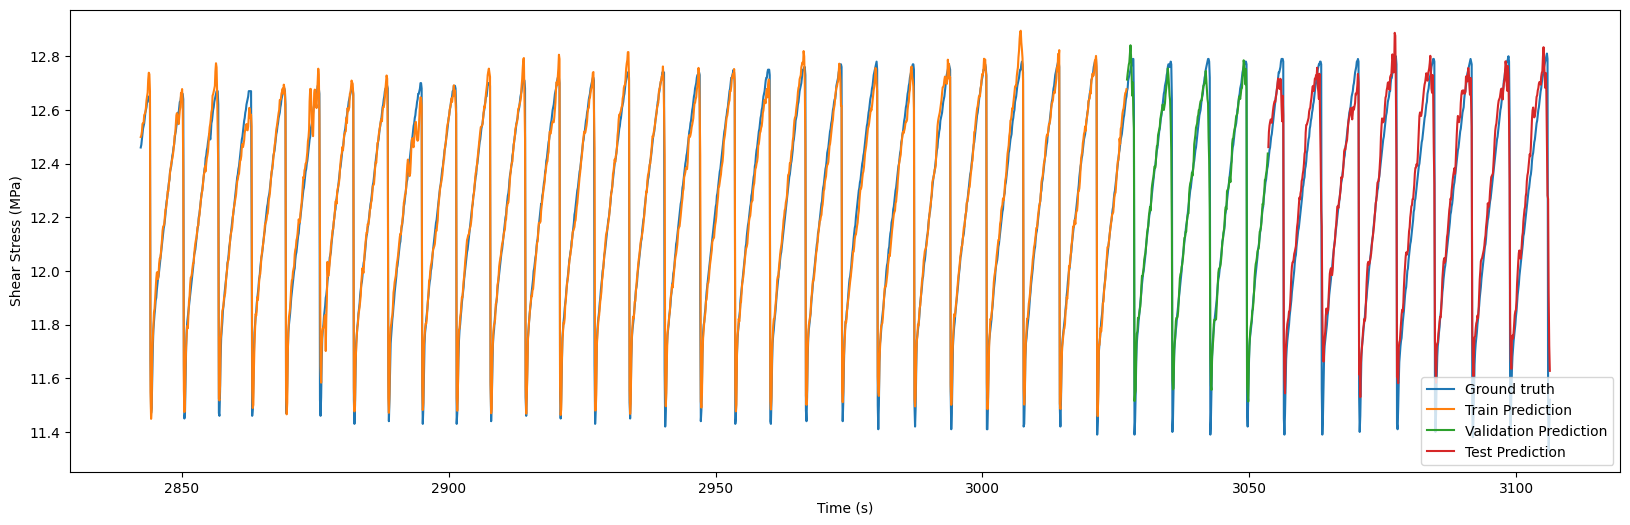

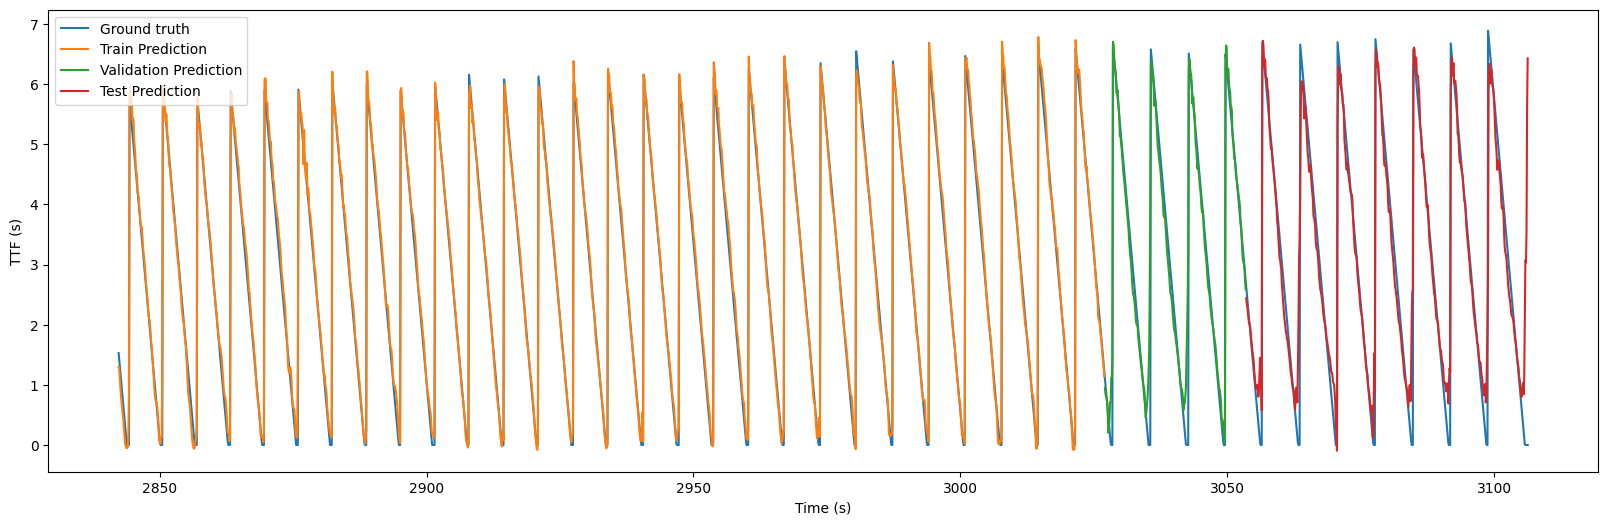

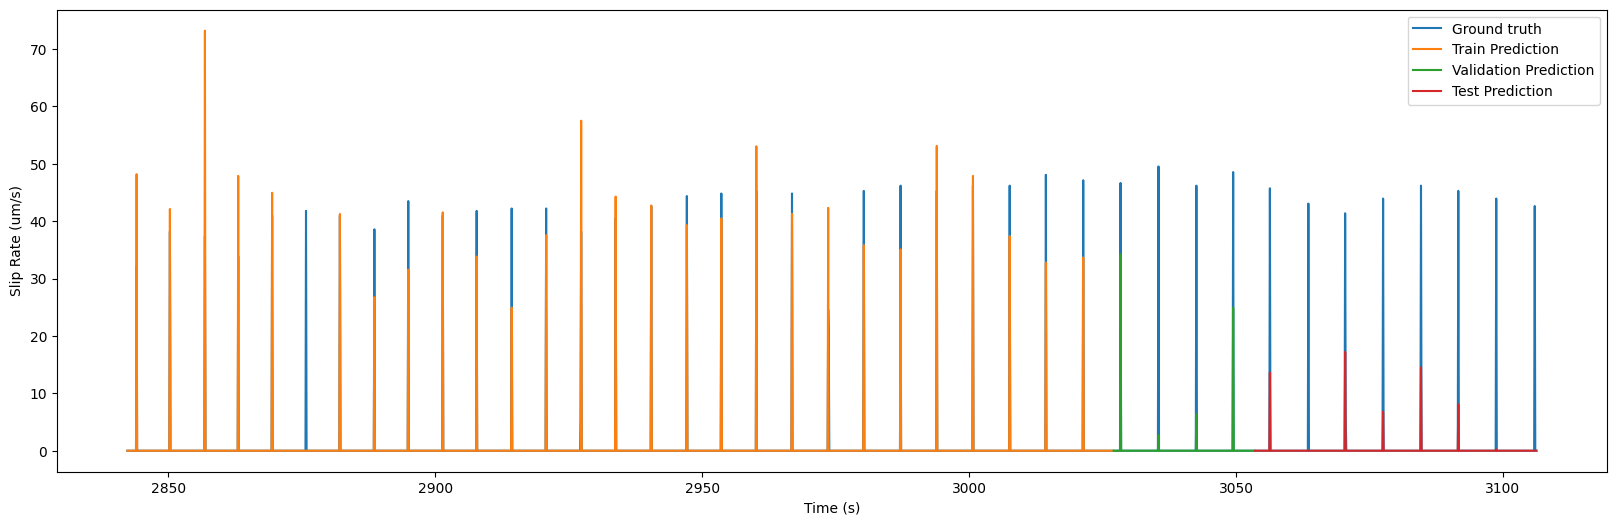

In [ ]:
# Overall plot:
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_TTF)
plt.plot(traintime, y_predtrain_TTF)
plt.plot(valtime,  y_predval_TTF)
plt.plot(testtime, y_predtest_TTF)
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

ydf_SR = np.exp(ydf_SR)*10;
y_predtrain_SR = np.exp(y_predtrain_SR)*10;
y_predval_SR = np.exp(y_predval_SR)*10;
y_predtest_SR = np.exp(y_predtest_SR)*10;

fig = plt.figure(3, figsize=(20,6))
plt.plot(ttime, ydf_SR)
plt.plot(traintime, y_predtrain_SR)
plt.plot(valtime,  y_predval_SR)
plt.plot(testtime, y_predtest_SR)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])


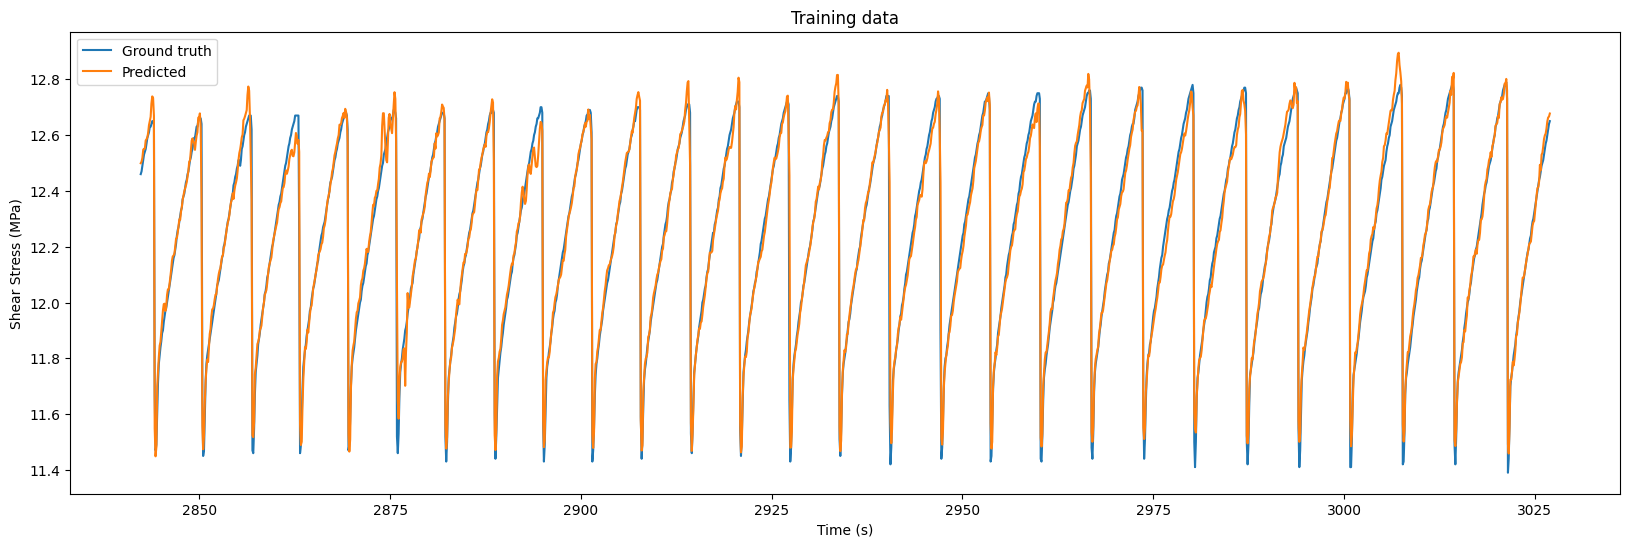

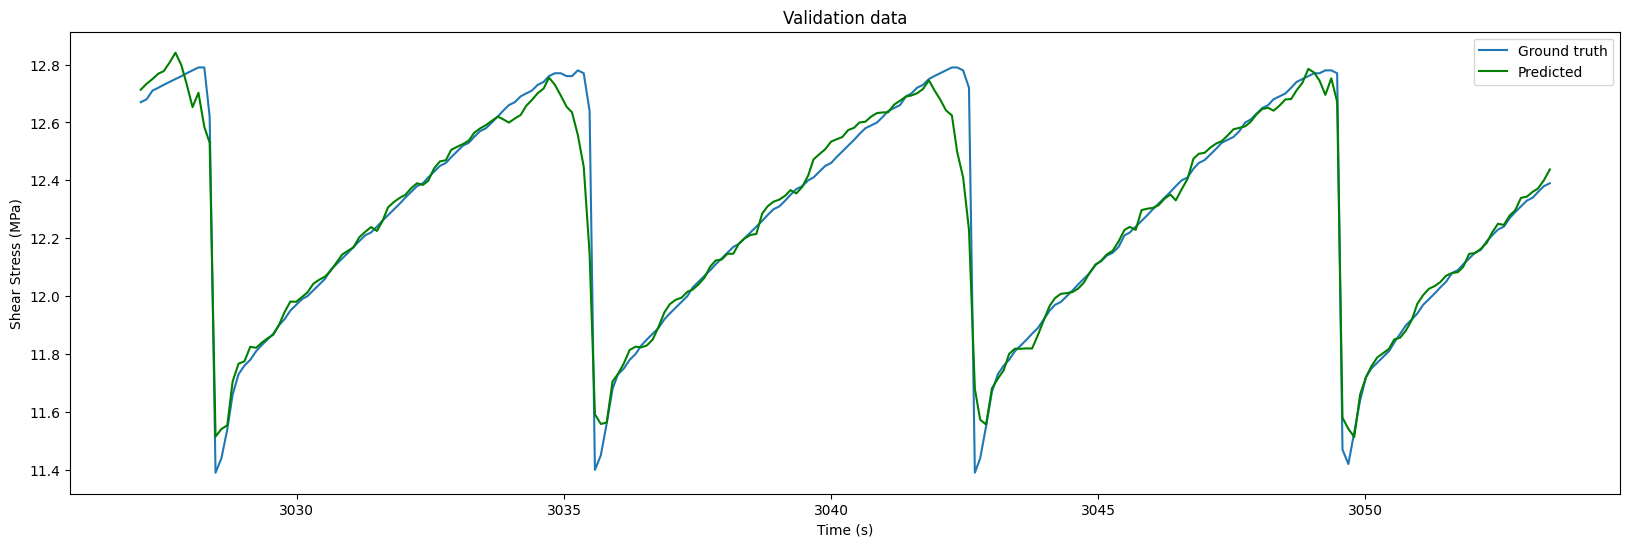

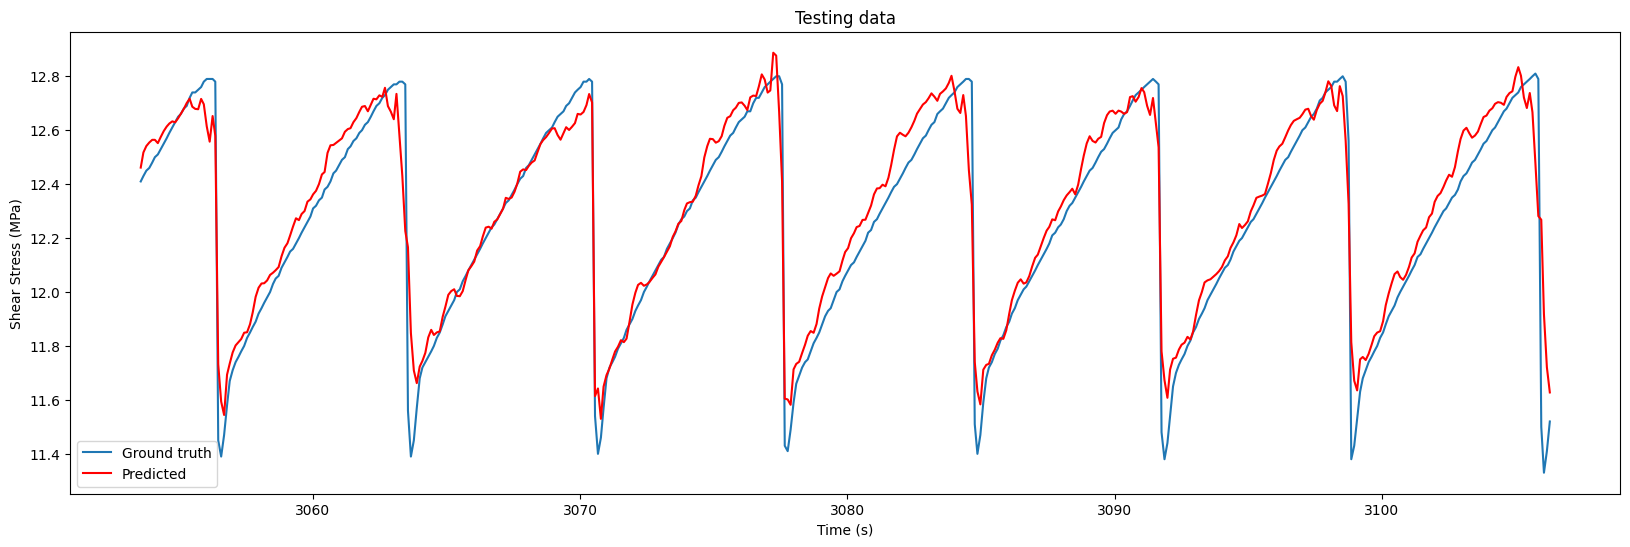

In [ ]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

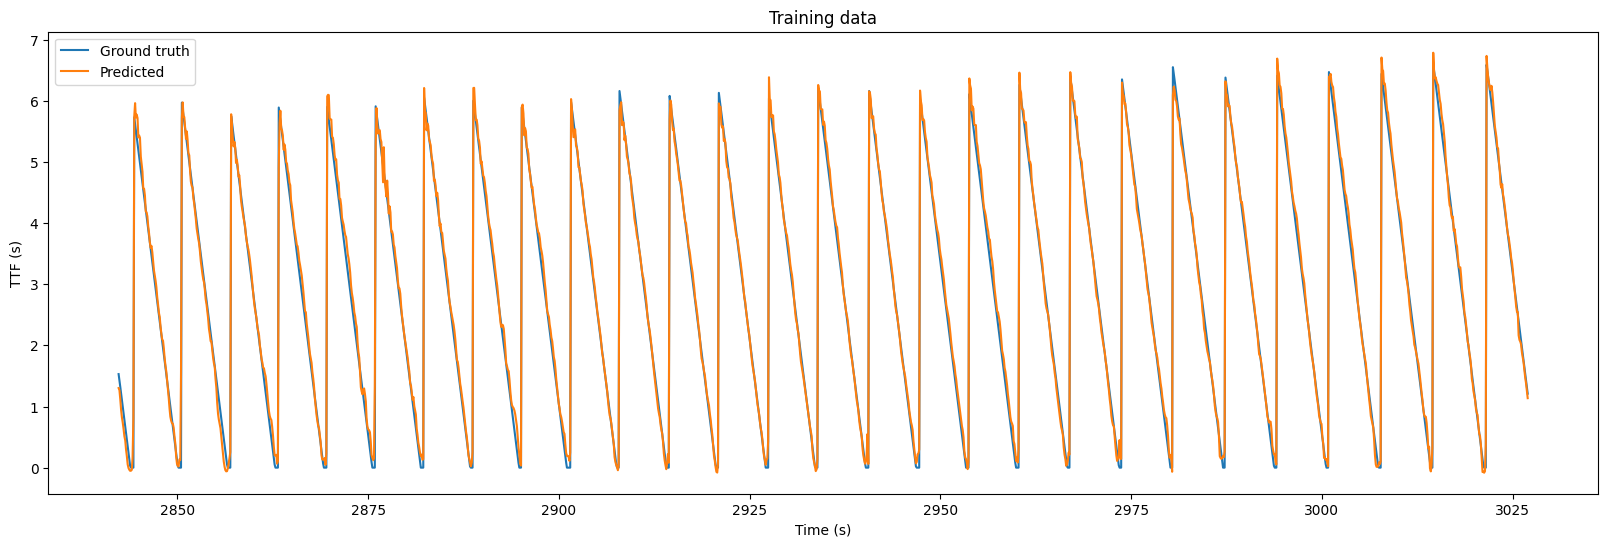

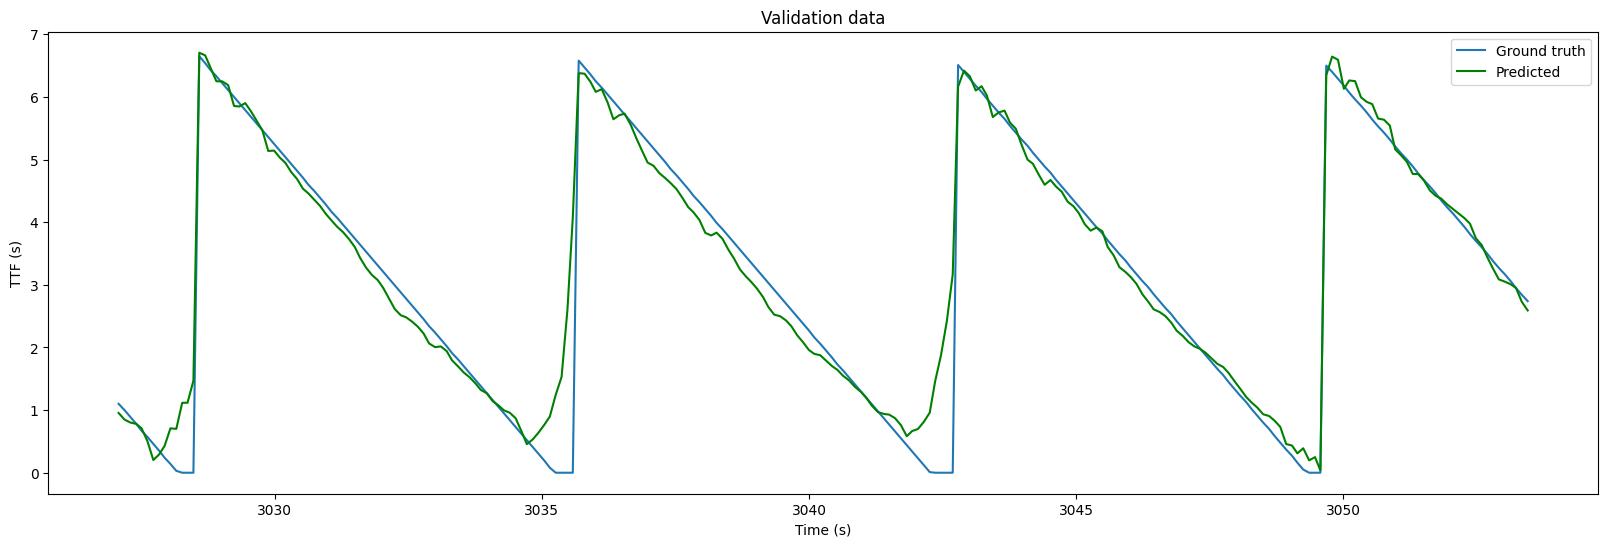

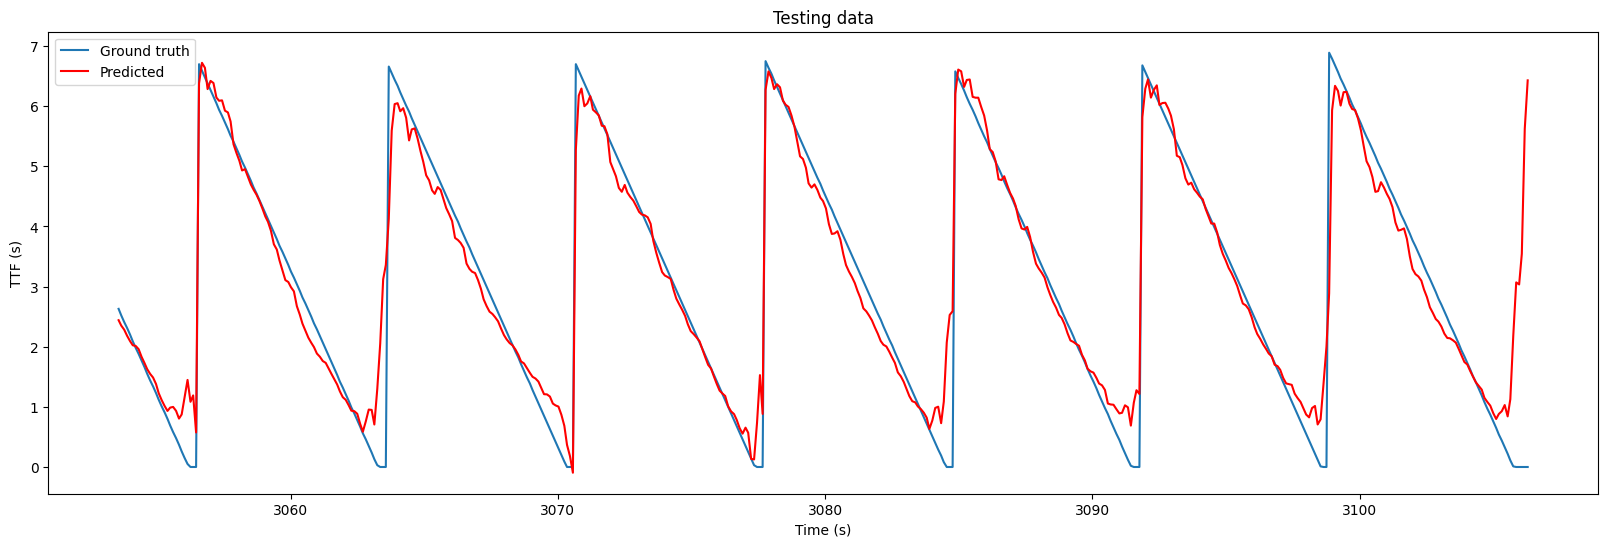

In [ ]:
# # Individual plot: TTF

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('TTF (s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_TTF, y_predtrain_TTF, 'Training data', '')
results_plot(2, valtime, Y_val_TTF, y_predval_TTF, 'Validation data', 'g')
results_plot(3, testtime, y_test_TTF, y_predtest_TTF, 'Testing data', 'r')

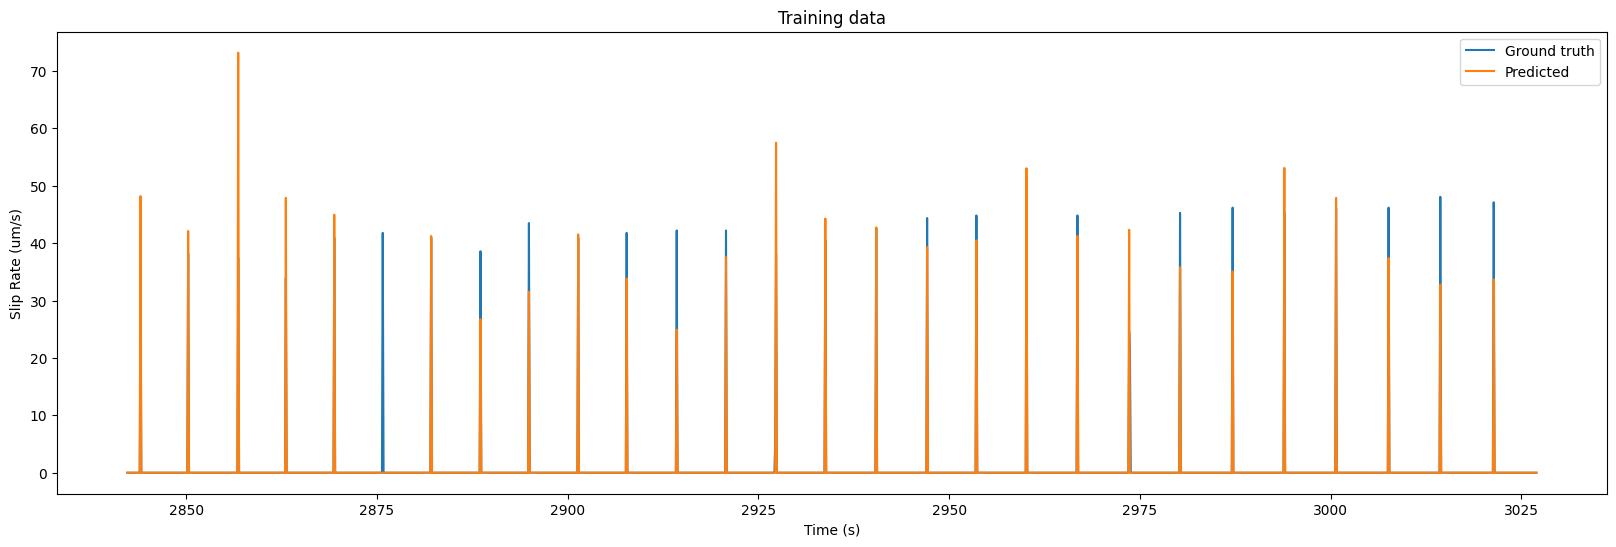

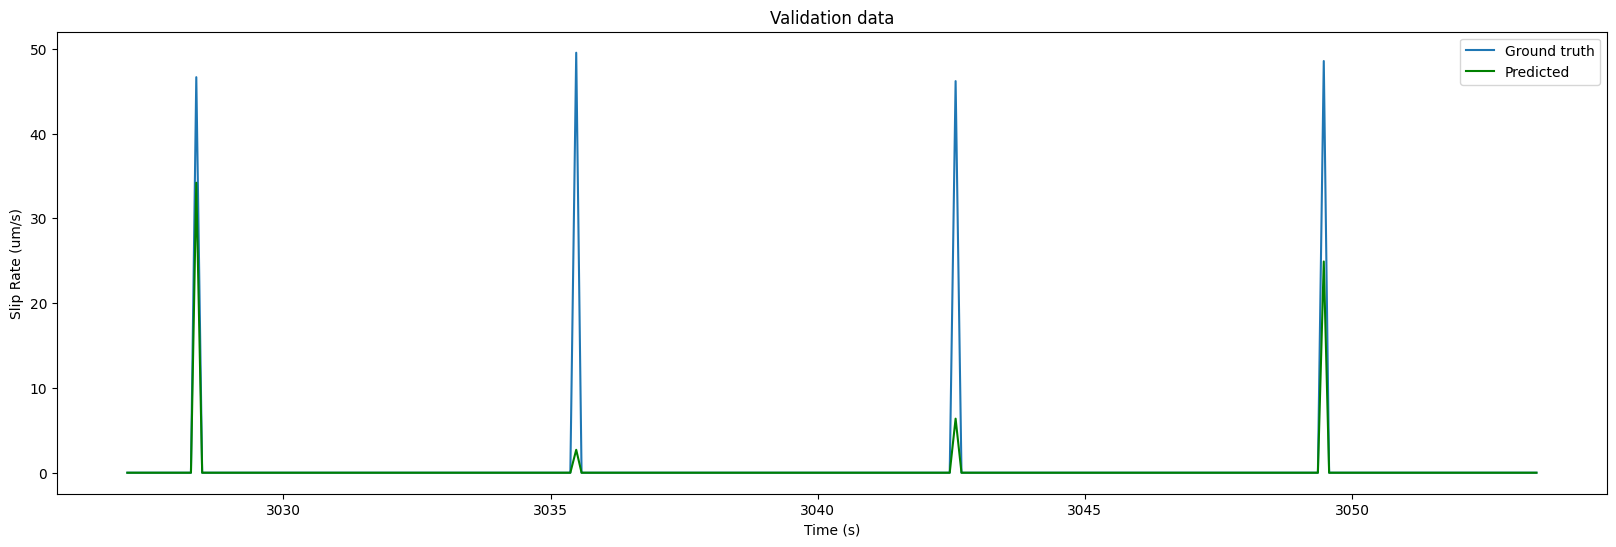

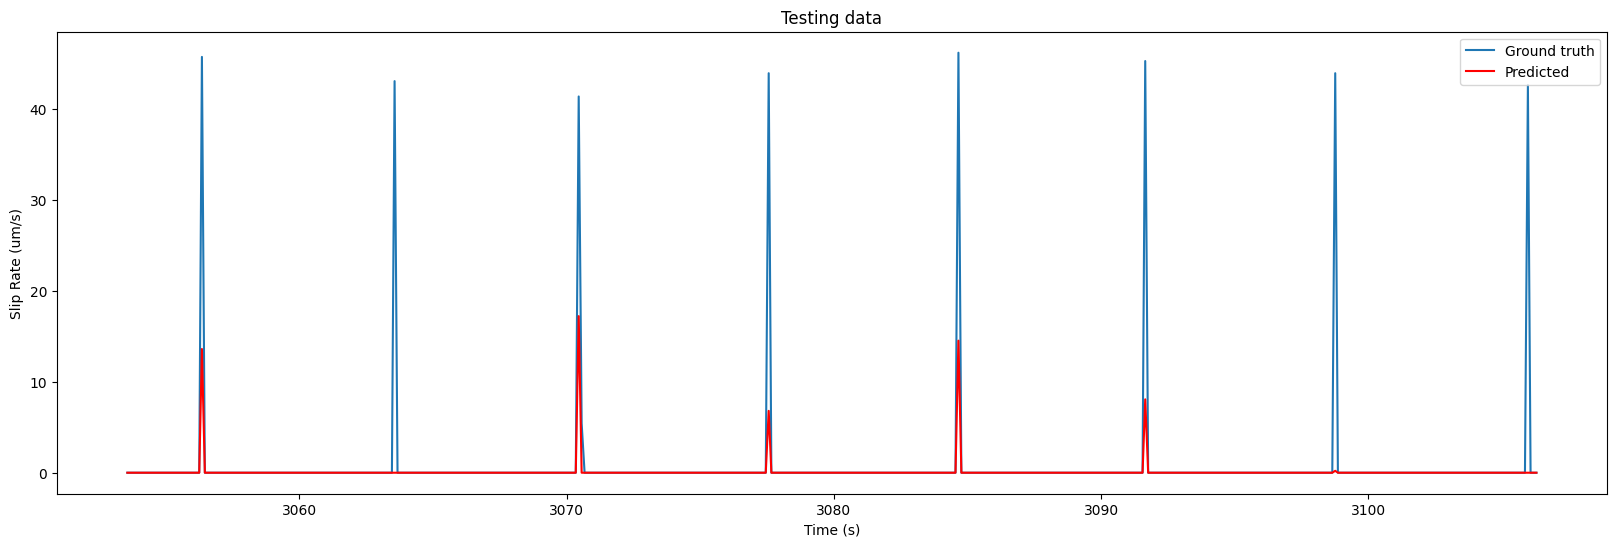

In [ ]:
# # Individual plot: SR
Y_train_SR = np.exp(Y_train_SR)*10;
Y_val_SR = np.exp(Y_val_SR)*10;
y_test_SR = np.exp(y_test_SR)*10;

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SR, y_predtrain_SR, 'Training data', '')
results_plot(2, valtime, Y_val_SR, y_predval_SR, 'Validation data', 'g')
results_plot(3, testtime, y_test_SR, y_predtest_SR, 'Testing data', 'r')